In [1]:
# Utilities
import numpy as np
import pandas as pd
from collections import defaultdict

# Text Related Library
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
from wordcloud import WordCloud,ImageColorGenerator

# Image Library
from imageio import imread, imwrite

# Plotting Library
import matplotlib.pyplot as plt

## Global Initialization

In [2]:
punctuation = set(string.punctuation)
stop_words = stopwords.words('english')
extra_stop_words = ['facebook','netflix','google','apple','amazon','microsoft','pros','cons','fb','lot','lots','also','thing','things','company','really','work','worked','working']
stop_words += extra_stop_words

## Load Data File 

In [3]:
datafile = 'employee_reviews.csv'
dataset = pd.read_csv(datafile)
print(dataset.shape)
print(dataset.describe())

(67529, 17)
         Unnamed: 0  overall-ratings  helpful-count
count  67529.000000     67529.000000   67529.000000
mean   33765.000000         3.826075       1.268211
std    19494.087501         1.154989      16.085852
min        1.000000         1.000000       0.000000
25%    16883.000000         3.000000       0.000000
50%    33765.000000         4.000000       0.000000
75%    50647.000000         5.000000       1.000000
max    67529.000000         5.000000    2094.000000


# Data Cleaning

## a) Remove Null and Out-Dated Data

In [4]:
# clean null
dataset = dataset.dropna()
# clean outdated data
dataset = dataset[dataset['dates'].str.split(', ').str.get(1) > '2012']
print(dataset.shape)
print(dataset.describe())

(58844, 17)
         Unnamed: 0  overall-ratings  helpful-count
count  58844.000000     58844.000000   58844.000000
mean   32173.819693         3.849245       1.179220
std    18940.901512         1.156144      16.987755
min        1.000000         1.000000       0.000000
25%    15814.750000         3.000000       0.000000
50%    31494.500000         4.000000       0.000000
75%    48487.500000         5.000000       1.000000
max    66440.000000         5.000000    2094.000000


## b) Type Unification

In [5]:
# change rating type to float
dataset["overall-ratings"] = pd.to_numeric(dataset["overall-ratings"],errors='coerce')
dataset["work-balance-stars"] = pd.to_numeric(dataset["work-balance-stars"],errors='coerce')
dataset["culture-values-stars"] = pd.to_numeric(dataset["culture-values-stars"],errors='coerce')
dataset["carrer-opportunities-stars"] = pd.to_numeric(dataset["carrer-opportunities-stars"],errors='coerce')
dataset["comp-benefit-stars"] = pd.to_numeric(dataset["comp-benefit-stars"],errors='coerce')
dataset["senior-mangemnet-stars"] = pd.to_numeric(dataset["senior-mangemnet-stars"],errors='coerce')
# change dates type to datetime
dataset['dates'] = pd.to_datetime(dataset['dates'], format=" %b %d, %Y")
print(dataset.dtypes)

Unnamed: 0                             int64
company                               object
location                              object
dates                         datetime64[ns]
job-title                             object
summary                               object
pros                                  object
cons                                  object
advice-to-mgmt                        object
overall-ratings                      float64
work-balance-stars                   float64
culture-values-stars                 float64
carrer-opportunities-stars           float64
comp-benefit-stars                   float64
senior-mangemnet-stars               float64
helpful-count                          int64
link                                  object
dtype: object


## c) Text Data Cleaning

In [6]:
def clean(s):
    
    # Remove punctuation and un-capitalize lettes
    r = ''
    for c in s.lower():
        if c in punctuation:
            r += ' '
        else:
            r += c
    r = ' '.join(r.split())
    
    # Remove stop words
    tokens = word_tokenize(r)
    s_new = ' '.join([w for w in tokens if not w in stop_words])
    
    return s_new

In [7]:
# Clean All Fields with Text Data
dataset['pros_clean'] = dataset['pros'].apply(clean)
dataset['cons_clean'] = dataset['cons'].apply(clean)
dataset['summary_clean'] = dataset['summary'].apply(clean)
dataset['advice-to-mgmt_clean'] = dataset['advice-to-mgmt'].apply(clean)

# Word Cloud

## Load Sentiment Words Files

In [8]:
with open('positive-words.txt') as infile:
    word_pos = [l[:-1] for l in infile if not l.startswith(';')]
with open('negative-words.txt',encoding = "ISO-8859-1") as infile:
    word_neg = [l[:-1] for l in infile if not l.startswith(';')]    

## Split Data (company-wise and rating-wise)

In [9]:
# Company wise data split
facebook = dataset[dataset['company'] == 'facebook']
netflix = dataset[dataset['company'] == 'netflix']
google = dataset[dataset['company'] == 'google']
apple = dataset[dataset['company'] == 'apple']
amazon = dataset[dataset['company'] == 'amazon']
microsoft = dataset[dataset['company'] == 'microsoft']
print('facebook: ', facebook.shape[0])
print('netflix:  ', netflix.shape[0])
print('google:   ', google.shape[0])
print('apple:    ', apple.shape[0])
print('amazon:   ', amazon.shape[0])
print('microsoft:', microsoft.shape[0])
print()

# Rating wise data split
five = dataset[dataset['overall-ratings'] == 5]
four = dataset[dataset['overall-ratings'] == 4]
three = dataset[dataset['overall-ratings'] == 3]
two = dataset[dataset['overall-ratings'] == 2]
one = dataset[dataset['overall-ratings'] == 1]
print('five:     ', five.shape[0])
print('four:     ', four.shape[0])
print('three:    ', three.shape[0])
print('two:      ', two.shape[0])
print('one:      ', one.shape[0])

facebook:  1305
netflix:   510
google:    6748
apple:     11227
amazon:    24931
microsoft: 14123

five:      20866
four:      19460
three:     10774
two:       4269
one:       3475


## Word Cloud Class

In [10]:
class Word_Cloud:
    def __init__(self):
        self.n = 2000
        self.d = None
        self.mask = None
        self.font_color = None
        self.background_color = None
        self.font = None
        self.width = 1000
        self.height = 1000
        
    # Set the working directory
    def set_directory(self,d):
        self.d = d
        
    # Set the number of words in frequency dictionary
    def set_number_of_words(self,n):
        self.n = n
        
    # Set the shape of the word cloud
    def set_mask(self,mask_file):
        self.mask = imread(self.d + mask_file)
        
    # Set the color for words in word cloud
    def set_font_color(self,color_file):
        self.font_color = ImageColorGenerator(imread(self.d + color_file))

    # Set the background color for the word cloud
    def set_background_color(self,c):
        self.background_color = c
        
    # Set the font for words in word cloud
    def set_font(self,font_file):
        self.font = self.d + font_file
        
    # Generate word frequency dictionary (top n most frequent words)
    def generate_word_frequency_dict(self,data):
        word_count = defaultdict(int)
        for r in data:
            if not isinstance(r,str): continue
            for w in r.split():
                word_count[w] += 1
        counts = [(word_count[w],w) for w in word_count]
        counts.sort()
        counts.reverse()
        words = {}
        for x in counts[:self.n]:
            if x[1] in stop_words or x[1].isdigit(): continue
            words[x[1]] = x[0]
        return words
    
    # Generate sentiment word frequency dictionary
    def generate_sentiment_wf_dict(self,data,direction):
        wfd = self.generate_word_frequency_dict(data)
        words = {}
        for w in wfd:
            if w in direction:
                words[w] = wfd[w]
                
        return words
    
    # Generate a default word cloud
    def generate_word_cloud_default(self,data,direction,use_sentiment=True):
        
        if(use_sentiment):
            fd = self.generate_sentiment_wf_dict(data,direction)
        else:
            fd = self.generate_word_frequency_dict(data)
        
        wordcloud = WordCloud(background_color=self.background_color,
                              scale=4,
                              width=self.width,
                              height=self.height)
        
        wordcloud.generate_from_frequencies(fd)
        plt.figure(figsize=(self.width/100,self.height/100))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    
    # Generate a customized word cloud
    def generate_word_cloud(self,data,direction,use_sentiment=True):
        
        if(use_sentiment):
            fd = self.generate_sentiment_wf_dict(data,direction)
        else:
            fd = self.generate_word_frequency_dict(data)
        
        wordcloud = WordCloud(background_color=self.background_color,
                          mask=self.mask,
                          stopwords=stop_words,
                          scale=4,
                          width=self.width,
                          height=self.height,
                          font_path=self.font)
        
        wordcloud.generate_from_frequencies(fd)
        wordcloud.recolor(color_func=self.font_color)
        plt.figure(figsize=(self.width/100,self.height/100))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

## Facebook

In [11]:
# Utility
wc_facebook = Word_Cloud()
wc_facebook.set_directory('wordCloud/fb/')
wc_facebook.set_mask('fb.png')
wc_facebook.set_font_color('fb_color.png')
wc_facebook.set_background_color('white')
wc_facebook.set_font('facebook-letter-faces.ttf')

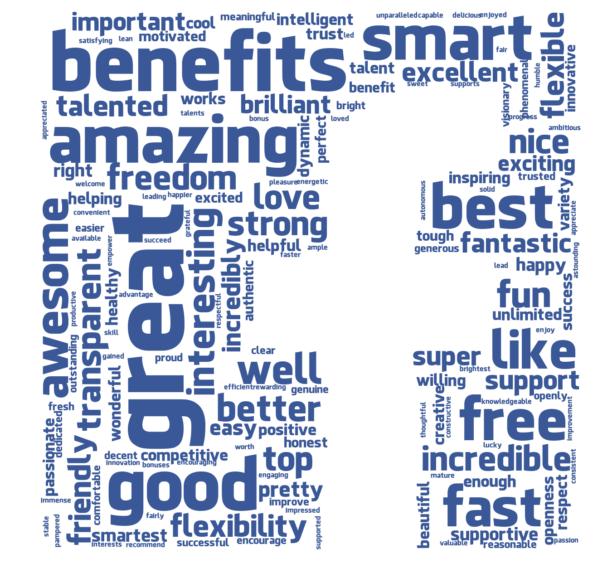

In [12]:
# Facebook Pros 
wc_facebook.generate_word_cloud(facebook['pros_clean'],word_pos)

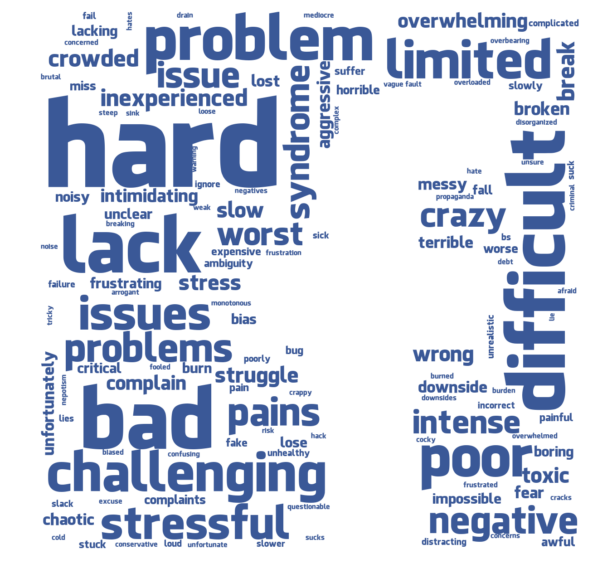

In [13]:
# Facebook Cons
wc_facebook.generate_word_cloud(facebook['cons_clean'],word_neg)

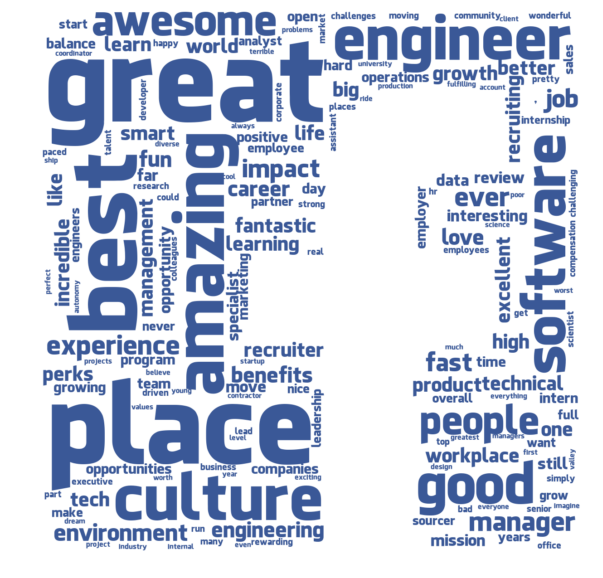

In [14]:
# Facebook Summary
wc_facebook.generate_word_cloud(facebook['summary_clean'],_,use_sentiment=False)

## Netflix

In [15]:
# Utility
wc_netflix = Word_Cloud()
wc_netflix.set_directory('wordCloud/netflix/')
wc_netflix.set_mask('netflix.png')
wc_netflix.set_font_color('netflix_color.png')
wc_netflix.set_background_color('black')
wc_netflix.set_font('netflix_font.otf')

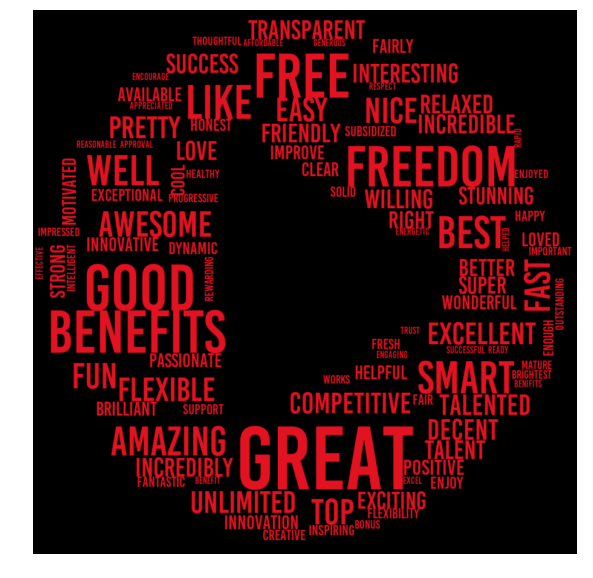

In [16]:
# Netflix Pros
wc_netflix.generate_word_cloud(netflix['pros_clean'],word_pos)

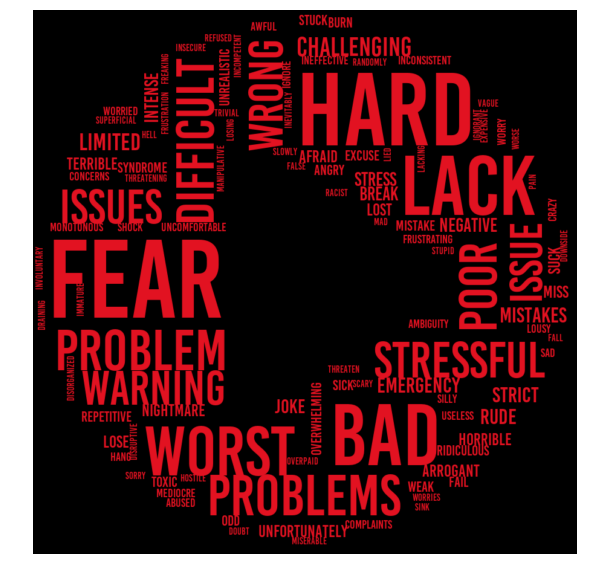

In [17]:
# Netflix Cons
wc_netflix.generate_word_cloud(netflix['cons_clean'],word_neg)

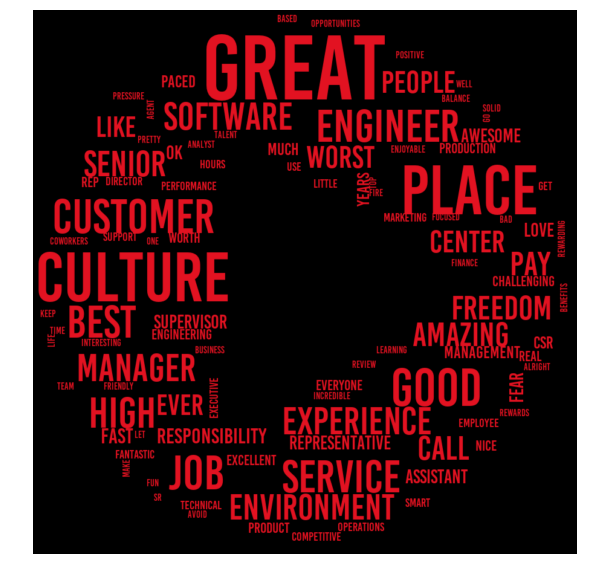

In [18]:
# Netflix Summary
wc_netflix.generate_word_cloud(netflix['summary_clean'],_,use_sentiment=False)

##  Google

In [19]:
# Utility
wc_google = Word_Cloud()
wc_google.set_directory('wordCloud/google/')
wc_google.set_mask('google.png')
wc_google.set_font_color('google_color.png')
wc_google.set_background_color('white')
wc_google.set_font('GoogleSans-Regular.ttf')

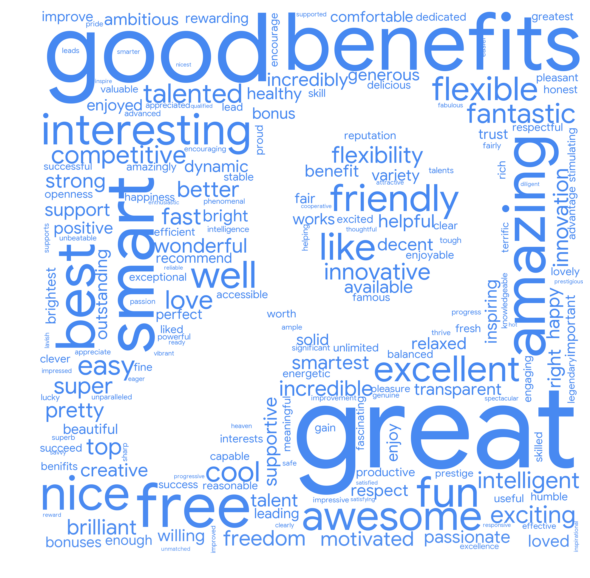

In [20]:
# Google Pros
wc_google.generate_word_cloud(google['pros_clean'],word_pos)

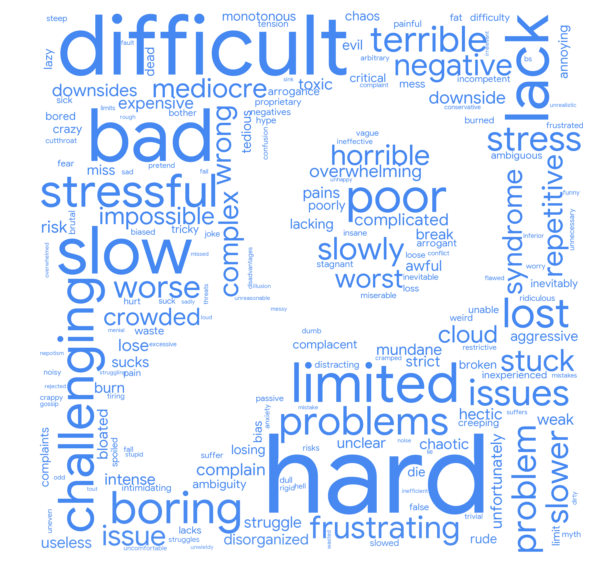

In [21]:
# Google Cons
wc_google.generate_word_cloud(google['cons_clean'],word_neg)

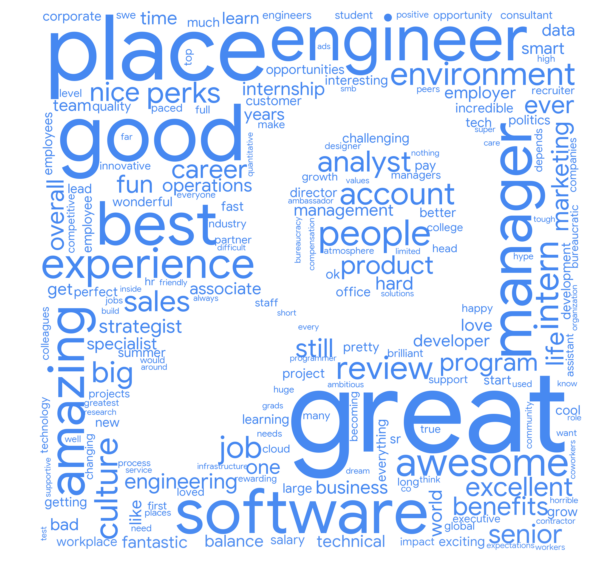

In [22]:
# Google Summary
wc_google.generate_word_cloud(google['summary_clean'],_,use_sentiment=False)

## Apple

In [23]:
# Utility
wc_apple = Word_Cloud()
wc_apple.set_directory('wordCloud/apple/')
wc_apple.set_mask('apple.png')
wc_apple.set_font_color('apple_color.png')
wc_apple.set_background_color('white')
wc_apple.set_font('SF-Pro-Display-Regular.otf')

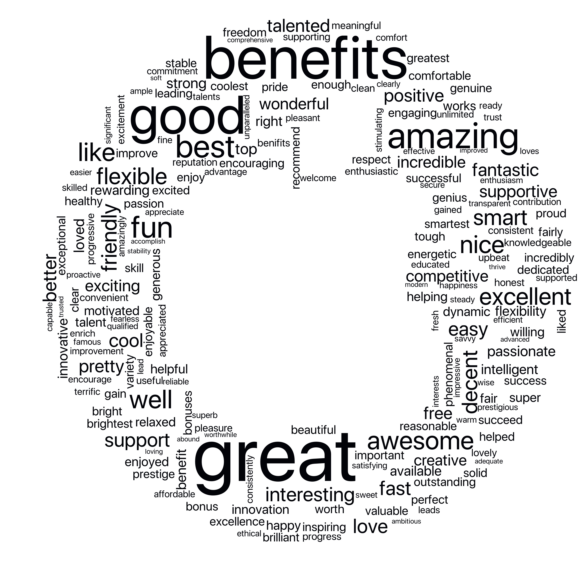

In [24]:
# Apple Pros
wc_apple.generate_word_cloud(apple['pros_clean'],word_pos)

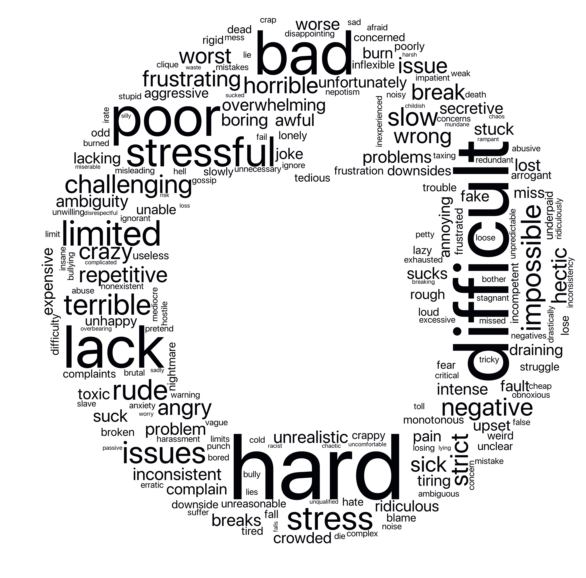

In [25]:
# Apple Cons
wc_apple.generate_word_cloud(apple['cons_clean'],word_neg)

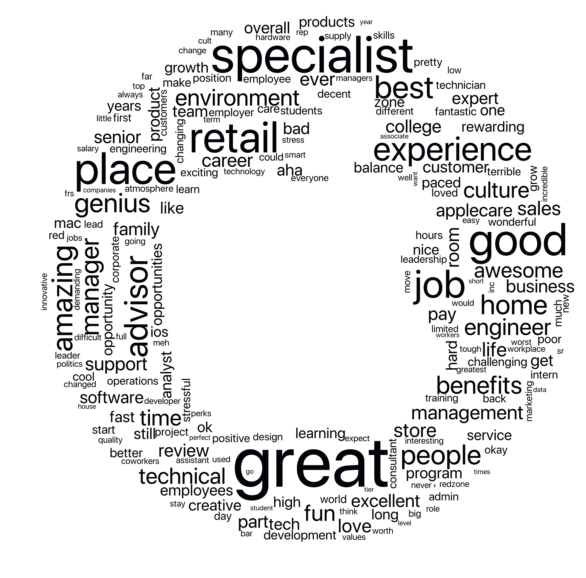

In [26]:
# Apple Summary
wc_apple.generate_word_cloud(apple['summary_clean'],_,use_sentiment=False)

## Amazon

In [27]:
# Utility
wc_amazon = Word_Cloud()
wc_amazon.set_directory('wordCloud/amazon/')
wc_amazon.set_mask('amazon.png')
wc_amazon.set_font_color('amazon_color.png')
wc_amazon.set_background_color('black')
wc_amazon.set_font('AmazonEmber_Bd.ttf')

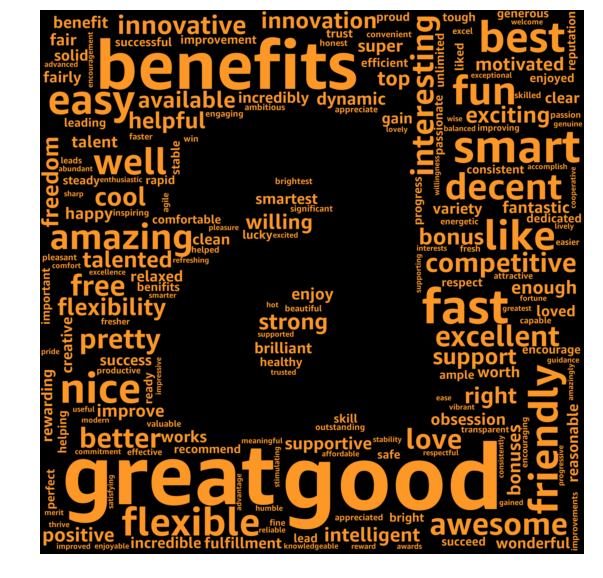

In [28]:
# Amazon Pros
wc_amazon.generate_word_cloud(amazon['pros_clean'],word_pos)

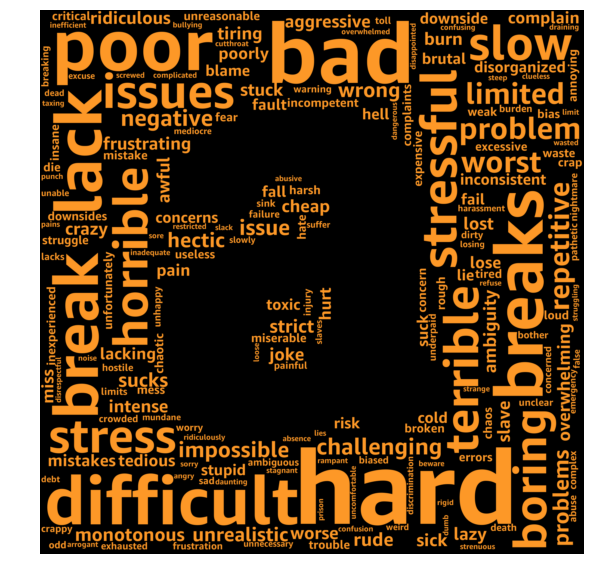

In [29]:
# Amazon Cons
wc_amazon.generate_word_cloud(amazon['cons_clean'],word_neg)

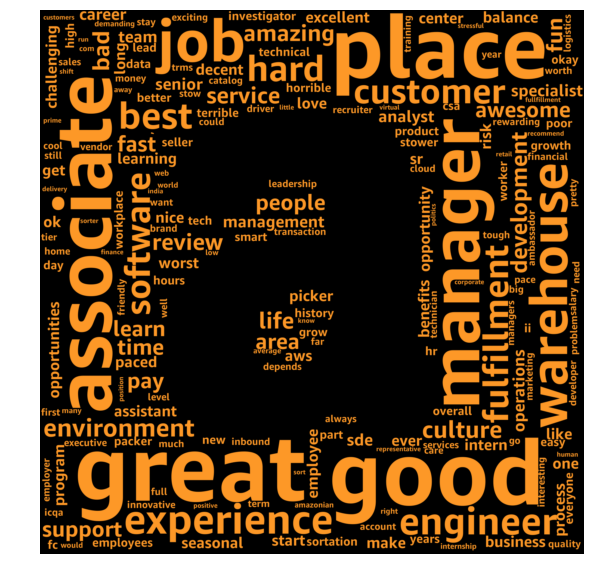

In [30]:
# Amazon Summary
wc_amazon.generate_word_cloud(amazon['summary_clean'],_,use_sentiment=False)

## Microsoft

In [31]:
# Utility
wc_microsoft = Word_Cloud()
wc_microsoft.set_directory('wordCloud/microsoft/')
wc_microsoft.set_mask('microsoft.png')
wc_microsoft.set_font_color('microsoft_color4.png')
wc_microsoft.set_background_color('black')
wc_microsoft.set_font('Microsoft_Logo.ttf')

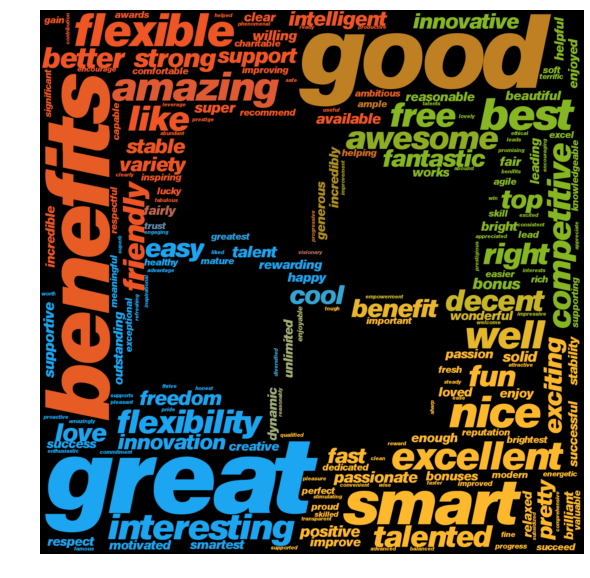

In [32]:
# Microsoft Pros
wc_microsoft.generate_word_cloud(microsoft['pros_clean'],word_pos)

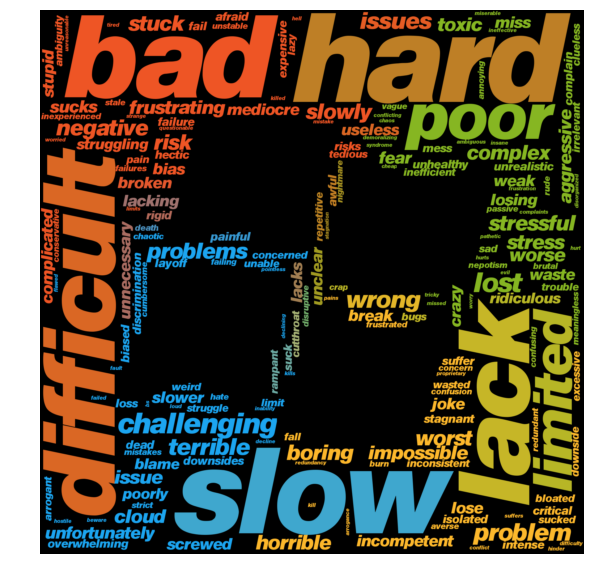

In [33]:
# Microsoft Cons
wc_microsoft.generate_word_cloud(microsoft['cons_clean'],word_neg)

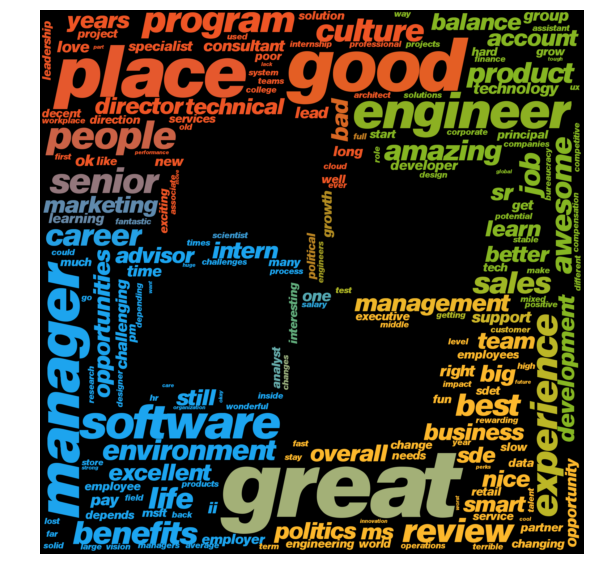

In [34]:
# Microsoft Summary
wc_microsoft.generate_word_cloud(microsoft['summary_clean'],_,use_sentiment=False)

## Ratings

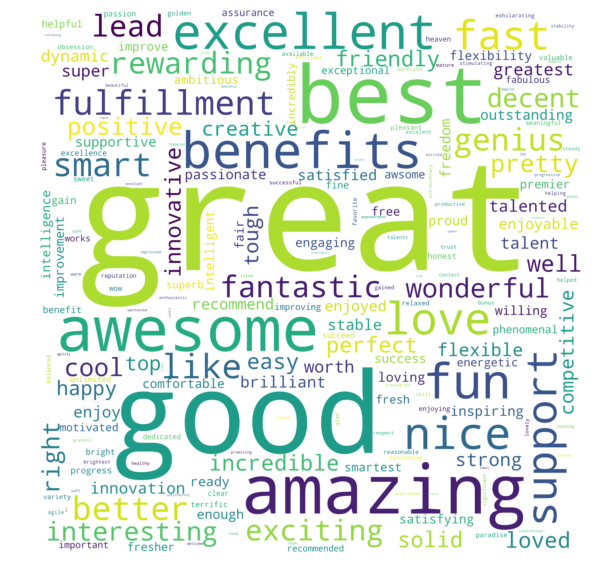

In [35]:
# 4 and 5 overall-ratings
wc_good_ratings = Word_Cloud()
wc_good_ratings.set_background_color('white')
data_good_ratings = list(five['summary_clean']) + list(four['summary_clean'])
wc_good_ratings.generate_word_cloud_default(data_good_ratings,word_pos)

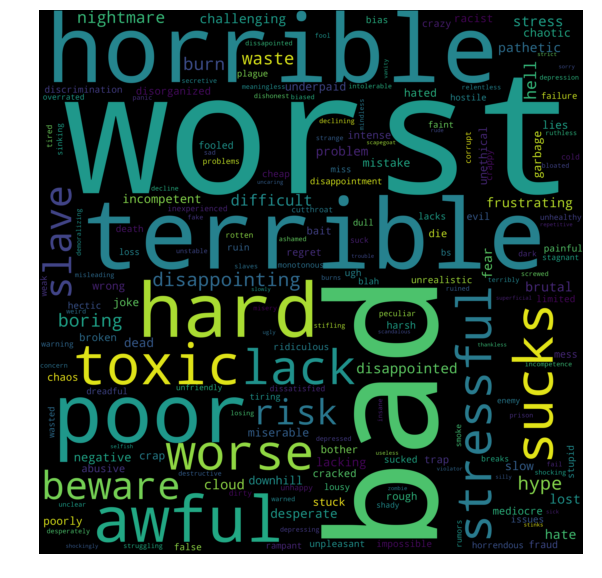

In [36]:
# 4 and 5 overall-ratings
wc_bad_ratings = Word_Cloud()
wc_bad_ratings.set_background_color('black')
data_bad_ratings = list(one['summary_clean']) + list(two['summary_clean'])
wc_bad_ratings.generate_word_cloud_default(data_bad_ratings,word_neg)